# 查看根目录下需要运行的文件夹

In [ ]:
from pathlib import Path
version = "v8"
if __name__ == "__main__":
    # === 1) 给定一个根目录 ===
    root_dir = Path("/workspace/models/SAHI/run_v7")
    # end_with = "_sliced"
    end_with = "_data"

    # === 2) 遍历所有子目录 ===
    sub_dirs = list(root_dir.glob("**/*" + end_with))


    if not sub_dirs:
        print(f"没有找到 *{end_with} 目录")
        exit(0)

    print(f"找到以下 {end_with} 数据集：")
    for i, d in enumerate(sub_dirs):
        print(f"[{i}] {d}")

    # === 3) 让你选择要跑的目录 ===
    idx_str = input("请输入要处理的编号 (多个用逗号分隔, 回车默认全选): ").strip()
    if idx_str:
        indices = [int(x) for x in idx_str.split(",")]
        chosen_dirs = [sub_dirs[i] for i in indices]
    else:
        chosen_dirs = sub_dirs
    
    print(f"将处理以下 {end_with} 目录：")
    for i, d in enumerate(chosen_dirs):
        print(f"- {i+1}. {d}")

    # 如果有的文件夹的raw_data里面没有图片，就移除
    chosen_dirs = [d for d in chosen_dirs if (d.parent / "raw_data").exists() and any((d.parent / "raw_data").glob("*.jpg"))]
    if not chosen_dirs:
        print(f"没有找到包含图片的 *{end_with} 目录")
        exit(0)

找到以下 _data 数据集：
[0] /workspace/models/SAHI/run_v7/ms1_0726-0809_11/raw_data
[1] /workspace/models/SAHI/run_v7/air1_0729-0813_5/raw_data
[2] /workspace/models/SAHI/run_v7/air1_0826-0909_21_no/raw_data
[3] /workspace/models/SAHI/run_v7/air2_0729-0813_04/raw_data
[4] /workspace/models/SAHI/run_v7/air2_0826-0909_25_no/raw_data
[5] /workspace/models/SAHI/run_v7/air2_0923-1007_02_wait/raw_data
[6] /workspace/models/SAHI/run_v7/jeff_0613-0624_04_ok/raw_data
[7] /workspace/models/SAHI/run_v7/jeff_0624-0702_01_ok/raw_data
[8] /workspace/models/SAHI/run_v7/jeff_0730-0813_01/raw_data
[9] /workspace/models/SAHI/run_v7/lloyd_0603-0618_31/raw_data
[10] /workspace/models/SAHI/run_v7/lloyd_0715-0729_04/raw_data
[11] /workspace/models/SAHI/run_v7/lloyd_0826-0909_04/raw_data
[12] /workspace/models/SAHI/run_v7/ms1_0605-0621_40/raw_data
[13] /workspace/models/SAHI/run_v7/ms1_0621-0710_04/raw_data
[14] /workspace/models/SAHI/run_v7/ms1_0710-0726_36/raw_data
[15] /workspace/models/SAHI/run_v7/ms1_0809-0823_

# 统计各类别数量并导出为CSV文件

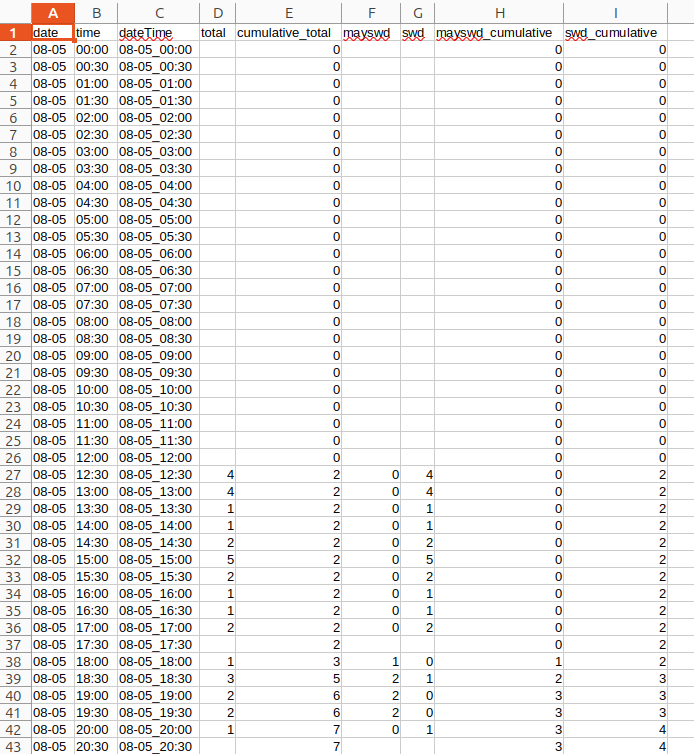

In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

from pathlib import Path
from collections import defaultdict, Counter
from typing import Any, Dict, Iterable, List, Optional, Tuple
import orjson, csv, re, math

# ============== 可选：shapely ==============
try:
    from shapely.geometry import Polygon
    _HAVE_SHAPELY = True
except Exception:
    _HAVE_SHAPELY = False

# ============== 时间解析 ==============
_FN_RE = re.compile(r"(?P<mm>\d{2})(?P<dd>\d{2})_(?P<hh>\d{2})(?P<mi>\d{2})")

def _parse_mmdd_hhmm(img_name: str):
    m = _FN_RE.search(img_name)
    if not m:
        return None
    mm, dd, hh, mi = m.group("mm", "dd", "hh", "mi")
    return f"{mm}-{dd}", f"{hh}:{mi}"

def _to_slot(time_str: str, step_min: int):
    hh, mi = map(int, time_str.split(":"))
    total_min = hh * 60 + mi
    slot_min = (total_min // step_min) * step_min
    h, m = divmod(slot_min, 60)
    return f"{h:02d}:{m:02d}"

def _day_slots(step_min: int):
    return [f"{(t//60):02d}:{(t%60):02d}" for t in range(0, 24*60, step_min)]

# ============== IO ==============
def _load_data(data_or_path):
    if isinstance(data_or_path, (dict, list)):
        return data_or_path
    p = Path(data_or_path)
    with p.open("rb") as f:
        return orjson.loads(f.read())

def save_csv(path: str | Path, header, rows):
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(header)
        w.writerows(rows)

# ============== 输入结构自适配 ==============
def _iter_image_groups(data, image_key=None):
    """
    支持两类输入：
      1) dict: { "IMGNAME": [ {label, points/segments/box/bbox, ...}, ... ], ... }
      2) list: [ {image: "IMGNAME", label: ..., ...}, ... ]
    """
    if isinstance(data, dict):
        for img, arr in data.items():
            if isinstance(arr, list):
                yield str(img), arr
    elif isinstance(data, list):
        buckets = defaultdict(list)
        cand = [image_key] if image_key else ["original_name", "image", "filename", "name"]
        for obj in data:
            if not isinstance(obj, dict):
                continue
            img = None
            for k in cand:
                if k and obj.get(k) is not None:
                    img = obj[k]; break
            if img is None:
                continue
            buckets[str(img)].append(obj)
        for img, arr in buckets.items():
            yield img, arr
    else:
        raise ValueError("不支持的 JSON 顶层结构")

# ============== 几何提取（polygon 优先） ==============
def _poly_from_segments(segments: Dict[str, List[float]]) -> Optional[List[List[float]]]:
    xs = segments.get("x") or segments.get("xs") or []
    ys = segments.get("y") or segments.get("ys") or []
    if not xs or not ys or len(xs) != len(ys):
        return None
    return [[float(x), float(y)] for x, y in zip(xs, ys)]

def _poly_from_bbox(b) -> Optional[List[List[float]]]:
    # 接受 [x,y,w,h] / {x,y,w,h} / [x1,y1,x2,y2] 这几类，统一为四角矩形 polygon
    if b is None: return None
    try:
        if isinstance(b, (list, tuple)) and len(b) >= 4:
            x, y, w, h = map(float, b[:4])
            if w > 0 and h > 0:
                x1, y1, x2, y2 = x, y, x + w, y + h
            else:
                # 可能已是 x1,y1,x2,y2
                x1, y1, x2, y2 = map(float, b[:4])
        elif isinstance(b, dict):
            if all(k in b for k in ("x1","y1","x2","y2")):
                x1, y1, x2, y2 = float(b["x1"]), float(b["y1"]), float(b["x2"]), float(b["y2"])
            else:
                x = float(b.get("x")); y = float(b.get("y"))
                w = float(b.get("w") or b.get("width")); h = float(b.get("h") or b.get("height"))
                x1, y1, x2, y2 = x, y, x + w, y + h
        else:
            return None
        if x2 <= x1 or y2 <= y1: return None
        return [[x1,y1],[x2,y1],[x2,y2],[x1,y2]]
    except Exception:
        return None

def _poly_from_obj(obj: Dict[str, Any]) -> Optional[List[List[float]]]:
    # 1) points（你清洗后的 annotations）
    pts = obj.get("points") or obj.get("polygon")
    if isinstance(pts, list) and len(pts) >= 3:
        return [[float(x), float(y)] for x, y in pts]
    # 2) segments {x:[], y:[]}
    seg = obj.get("segments") or obj.get("segment")
    if isinstance(seg, dict):
        p = _poly_from_segments(seg)
        if p: return p
    # 3) box / bbox
    box = obj.get("box") or obj.get("Box") or None
    if box is not None:
        p = _poly_from_bbox(box)
        if p: return p
    bb = obj.get("bbox") or obj.get("BBox") or None
    if bb is not None:
        p = _poly_from_bbox(bb)
        if p: return p
    return None

def _poly_to_bbox(poly: List[List[float]]) -> Tuple[float,float,float,float]:
    xs = [p[0] for p in poly]; ys = [p[1] for p in poly]
    return min(xs), min(ys), max(xs), max(ys)

def _bbox_center(b: Tuple[float,float,float,float]) -> Tuple[float,float]:
    return (b[0]+b[2]) * 0.5, (b[1]+b[3]) * 0.5

def _center_distance(b1, b2) -> float:
    c1 = _bbox_center(b1); c2 = _bbox_center(b2)
    return math.hypot(c1[0]-c2[0], c1[1]-c2[1])

# ============== 匹配度量（IOS/IOU，Polygon 优先） ==============
def _area_bbox(b):
    return max(0.0, b[2]-b[0]) * max(0.0, b[3]-b[1])

def _iou_bbox(a, b) -> float:
    xA = max(a[0], b[0]); yA = max(a[1], b[1])
    xB = min(a[2], b[2]); yB = min(a[3], b[3])
    inter = max(0.0, xB-xA) * max(0.0, yB-yA)
    if inter <= 0: return 0.0
    u = _area_bbox(a) + _area_bbox(b) - inter
    return inter / u if u > 0 else 0.0

def _ios_bbox(a, b) -> float:
    xA = max(a[0], b[0]); yA = max(a[1], b[1])
    xB = min(a[2], b[2]); yB = min(a[3], b[3])
    inter = max(0.0, xB-xA) * max(0.0, yB-yA)
    if inter <= 0: return 0.0
    smaller = min(_area_bbox(a), _area_bbox(b))
    return inter / smaller if smaller > 0 else 0.0

def _iou_poly(pa: List[List[float]], pb: List[List[float]]) -> float:
    if not _HAVE_SHAPELY:
        return _iou_bbox(_poly_to_bbox(pa), _poly_to_bbox(pb))
    try:
        A = Polygon(pa); B = Polygon(pb)
        inter = A.intersection(B).area
        if inter <= 0: return 0.0
        u = A.area + B.area - inter
        return inter / u if u > 0 else 0.0
    except Exception:
        return _iou_bbox(_poly_to_bbox(pa), _poly_to_bbox(pb))

def _ios_poly(pa: List[List[float]], pb: List[List[float]]) -> float:
    if not _HAVE_SHAPELY:
        return _ios_bbox(_poly_to_bbox(pa), _poly_to_bbox(pb))
    try:
        A = Polygon(pa); B = Polygon(pb)
        inter = A.intersection(B).area
        if inter <= 0: return 0.0
        smaller = min(A.area, B.area)
        return inter / smaller if smaller > 0 else 0.0
    except Exception:
        return _ios_bbox(_poly_to_bbox(pa), _poly_to_bbox(pb))

# ============== 主函数：时间序列 + “跨时刻去重累计” ==============
def build_time_series(
    data_or_path,
    step_min: int = 30,
    fill_full_day: bool = True,
    label_key: str = "label",
    image_key: str | None = None,
    pad_value: str = "",
    # —— 累计去重参数（对齐你的后处理） ——
    cumulative: bool = True,
    match_metric: str = "poly_ios",        # 'poly_ios' | 'poly_iou' | 'bbox_ios' | 'bbox_iou' | None(简单相加)
    match_threshold: float = 0.5,
    center_thresh: Optional[float] = 20.0, # None 表示不限制中心距离
    class_agnostic: bool = False,          # False=仅同类匹配判同一只；True=跨类也可
    carry_cum_on_pad: bool = False,        # True=补齐行继承累计值；False=补齐行写 pad_value
):
    """
    返回 (header, rows)
    header: ["date","time","dateTime","total","cumulative_total", <label1>, ..., <labelN>, "<label1>_cumulative", ..., "<labelN>_cumulative"]

    说明：
      * total：该时间槽真实目标数（按 label 汇总）
      * cumulative_total：自序列开始到当前行的“唯一只数”累计（跨时刻去重）
      * <label>_cumulative：对应类别自序列开始到当前行的累计“唯一只数”
      * 若 match_metric=None，则累计为简单逐时刻求和（不去重）
      * class_agnostic=True 时，跨类去重，同一只在首次出现时被计入“当时的类别”的累计；之后即使换类名也不再计入其它类的累计
      * 补齐行（没有原始图像的时刻）：total/各 label/各累计列统一写 pad_value，
        若 carry_cum_on_pad=True，则累计列（总累计与各类累计）继承上一非补齐行的值
    """
    data = _load_data(data_or_path)

    # ====== 收集每张图的计数 + 几何明细 ======
    per_img_counts: Dict[str, Counter] = {}
    per_img_dets: Dict[str, List[Dict[str, Any]]] = defaultdict(list)
    all_labels = set()

    for img, arr in _iter_image_groups(data, image_key=image_key):
        c = Counter()
        dets = []
        for obj in arr:
            if not isinstance(obj, dict):
                continue
            label = obj.get(label_key) or obj.get("class_name") or obj.get("category")
            if label is None:
                continue
            label = str(label)
            all_labels.add(label)
            # 计数
            c[label] += 1
            # 几何
            poly = _poly_from_obj(obj)  # 优先 polygon
            dets.append({"label": label, "poly": poly})

        if c:
            per_img_counts[img] = c
            per_img_dets[img] = dets

    if not per_img_counts:
        raise ValueError("没有统计到任何数据（检查 label_key / image_key / JSON 结构）")

    labels_sorted = sorted(all_labels)

    # ====== 聚合到 (date, time_slot) ======
    ts_counts = defaultdict(lambda: defaultdict(Counter))  # date -> time -> Counter
    ts_dets   = defaultdict(lambda: defaultdict(list))     # date -> time -> List[det]
    present_times = defaultdict(set)                       # 真实存在的时刻
    dates = set()

    for img, cnt in per_img_counts.items():
        parsed = _parse_mmdd_hhmm(img)
        if not parsed:
            continue
        d, t_raw = parsed
        dates.add(d)
        slot = _to_slot(t_raw, step_min)

        ts_counts[d][slot].update(cnt)
        present_times[d].add(slot)

        # 把该图所有 det 放到该时刻
        ts_dets[d][slot].extend(per_img_dets.get(img, []))

    if not dates:
        raise ValueError("文件名未匹配到 MMDD_HHMM，无法生成时间序列。")

    # ====== 补齐全天 ======
    all_slots = _day_slots(step_min)
    if fill_full_day:
        for d in dates:
            for t in all_slots:
                _ = ts_counts[d][t]   # 触发创建

    # ====== 匹配函数（跨时刻去重用） ======
    def _match_score(poly_a: Optional[List[List[float]]], poly_b: Optional[List[List[float]]]) -> float:
        if match_metric is None:
            return 0.0
        mode = match_metric.lower()
        if "poly" in mode and (poly_a is not None) and (poly_b is not None):
            return _ios_poly(poly_a, poly_b) if "ios" in mode else _iou_poly(poly_a, poly_b)
        # 退化到 bbox
        ba = _poly_to_bbox(poly_a) if poly_a is not None else None
        bb = _poly_to_bbox(poly_b) if poly_b is not None else None
        if (ba is None) or (bb is None):
            return 0.0
        if center_thresh is not None and _center_distance(ba, bb) > center_thresh:
            return 0.0
        return _ios_bbox(ba, bb) if "ios" in mode else _iou_bbox(ba, bb)

    # ====== 输出 ======
    header = ["date", "time", "dateTime", "total"]
    if cumulative:
        header.append("cumulative_total")
    header.extend(labels_sorted)
    if cumulative:
        header.extend([f"{lbl}_cumulative" for lbl in labels_sorted])

    rows = []
    def date_key(d): return (int(d[:2]), int(d[3:]))

    # —— 跨时刻“已见库”与累计 —— 
    running_cum = 0
    running_cum_by_label = {lbl: 0 for lbl in labels_sorted}

    if class_agnostic:
        seen_pool: List[Dict[str, Any]] = []  # [{'label', 'poly'}]
    else:
        seen_pool_by_label = defaultdict(list) # label -> List[{'label','poly'}]

    def _already_seen(det: Dict[str,Any]) -> bool:
        if match_metric is None:
            return False
        pool = seen_pool if class_agnostic else seen_pool_by_label[det["label"]]
        for s in pool:
            # center_thresh 对 polygon 也有效（用 bbox 中心距离）
            if center_thresh is not None:
                ba = _poly_to_bbox(det["poly"]) if det["poly"] is not None else None
                bb = _poly_to_bbox(s["poly"])   if s["poly"]   is not None else None
                if ba is not None and bb is not None and _center_distance(ba, bb) > center_thresh:
                    continue
            if _match_score(det["poly"], s["poly"]) >= match_threshold:
                return True
        return False

    def _remember(det: Dict[str,Any]):
        if class_agnostic:
            seen_pool.append({"label": det["label"], "poly": det["poly"]})
        else:
            seen_pool_by_label[det["label"]].append({"label": det["label"], "poly": det["poly"]})

    # ====== 逐时刻生成行 ======
    for d in sorted(dates, key=date_key):
        times = all_slots if fill_full_day else sorted(ts_counts[d].keys(), key=lambda s: (int(s[:2]), int(s[3:])))
        for t in times:
            dt = f"{d}_{t}"
            c = ts_counts[d].get(t, Counter())
            is_pad = (t not in present_times[d])

            if is_pad:
                # —— 补齐行 —— 
                base = [d, t, dt, pad_value]
                if cumulative:
                    base.append(running_cum if carry_cum_on_pad else pad_value)
                # 每类计数
                base.extend([pad_value] * len(labels_sorted))
                # 每类累计
                if cumulative:
                    if carry_cum_on_pad:
                        base.extend([running_cum_by_label[lbl] for lbl in labels_sorted])
                    else:
                        base.extend([pad_value] * len(labels_sorted))
                rows.append(base)
                continue

            total_now = sum(c.values())

            # —— 本时刻内部去重 —— 
            dets_raw = ts_dets[d].get(t, [])
            unique_now: List[Dict[str,Any]] = []
            for det in dets_raw:
                poly = det.get("poly")
                label = det.get("label", "")
                cur = {"label": label, "poly": poly}

                dup_in_row = False
                for u in unique_now:
                    if (not class_agnostic) and (u["label"] != cur["label"]):
                        continue
                    if center_thresh is not None:
                        bu = _poly_to_bbox(u["poly"]) if u["poly"] is not None else None
                        bc = _poly_to_bbox(cur["poly"]) if cur["poly"] is not None else None
                        if bu is not None and bc is not None and _center_distance(bu, bc) > center_thresh:
                            continue
                    if _match_score(u["poly"], cur["poly"]) >= match_threshold:
                        dup_in_row = True
                        break
                if not dup_in_row:
                    unique_now.append(cur)

            # —— 与历史库比较，统计“新出现”的只数（总 & 分类）——
            if cumulative:
                if match_metric is not None:
                    new_by_label = Counter()
                    for det in unique_now:
                        if not _already_seen(det):
                            new_by_label[det["label"]] += 1
                            _remember(det)
                    # 更新累计
                    inc_total = sum(new_by_label.values())
                    running_cum += inc_total
                    for lbl in labels_sorted:
                        running_cum_by_label[lbl] += new_by_label.get(lbl, 0)
                else:
                    # 简单累计（不去重）
                    running_cum += total_now
                    for lbl in labels_sorted:
                        running_cum_by_label[lbl] += c.get(lbl, 0)

            # —— 写行 —— 
            row = [d, t, dt, total_now]
            if cumulative:
                row.append(running_cum)
            # 各类即时计数
            row.extend([c.get(lbl, 0) for lbl in labels_sorted])
            # 各类累计
            if cumulative:
                row.extend([running_cum_by_label[lbl] for lbl in labels_sorted])

            rows.append(row)

    return header, rows

In [10]:
for d in chosen_dirs:
    print(f"\n=========处理目录：{d} =========")
    try:
        header, rows = build_time_series(
            data_or_path= d.parent / "raw_data_sliced_merge" / f"filtered_annotations_{version}.json",
            step_min=30,
            fill_full_day=True,
            label_key="label",
            image_key=None,
            pad_value="",

            # —— 关键：跨时刻去重参数（与你现有后处理逻辑一致）——
            cumulative=True,
            match_metric="poly_ios",     # 'poly_ios' | 'poly_iou' | 'bbox_ios' | 'bbox_iou' | None
            match_threshold=0.5,
            center_thresh=20.0,          # 依据像素尺度调整
            class_agnostic=False,        # True = 不分类别地判“同一只”
            carry_cum_on_pad=True,        # 补齐行继承累计值
        )
    except Exception as e:
        print(f"处理失败: {e}")
        continue

    save_csv(d.parent / "raw_data_sliced_merge" / f"time_series_{version}.csv", header, rows)
    print(f"已保存到 {d.parent / 'raw_data_sliced_merge' / f'time_series_{version}.csv'}")



=========处理目录：/workspace/models/SAHI/run_v7/ms1_0726-0809_11/raw_data =========
已保存到 /workspace/models/SAHI/run_v7/ms1_0726-0809_11/raw_data_sliced_merge/time_series_v8.csv

=========处理目录：/workspace/models/SAHI/run_v7/air1_0729-0813_5/raw_data =========
已保存到 /workspace/models/SAHI/run_v7/air1_0729-0813_5/raw_data_sliced_merge/time_series_v8.csv

=========处理目录：/workspace/models/SAHI/run_v7/air1_0826-0909_21_no/raw_data =========
已保存到 /workspace/models/SAHI/run_v7/air1_0826-0909_21_no/raw_data_sliced_merge/time_series_v8.csv

=========处理目录：/workspace/models/SAHI/run_v7/air2_0729-0813_04/raw_data =========
已保存到 /workspace/models/SAHI/run_v7/air2_0729-0813_04/raw_data_sliced_merge/time_series_v8.csv

=========处理目录：/workspace/models/SAHI/run_v7/air2_0826-0909_25_no/raw_data =========
已保存到 /workspace/models/SAHI/run_v7/air2_0826-0909_25_no/raw_data_sliced_merge/time_series_v8.csv

=========处理目录：/workspace/models/SAHI/run_v7/jeff_0613-0624_04_ok/raw_data =========
已保存到 /workspace/models/SAHI

## 绘图

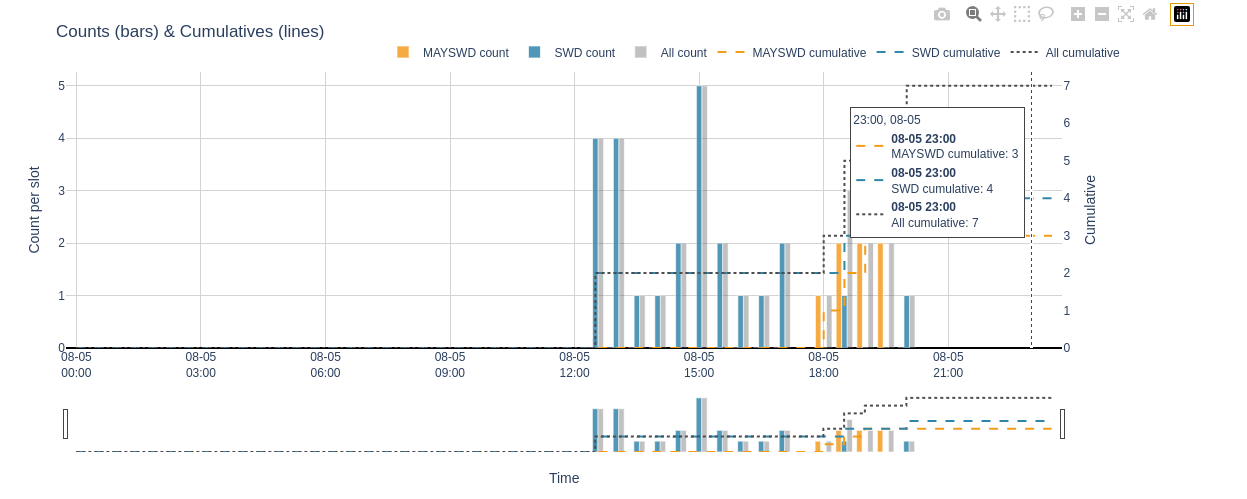

In [18]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

pio.templates.default = "plotly_white"

def plot_trap_timeseries(
    csv_path: str,
    *,
    title: str | None = None,
    barmode: str = "group",          # "group" 或 "stack"
    save_html: str | None = None,    # 例如 "/tmp/plot.html"
    width: int = 1200,
    height: int = 520,
):
    """
    读取 time_series.csv 并绘制：左轴柱状(各类/All count) + 右轴累计阶梯线(各类/All cumulative)。
    你只需改 csv_path 即可。
    """
    df = pd.read_csv(csv_path)

    # ---- 时间列统一 ----
    if "dt" in df.columns and pd.api.types.is_datetime64_any_dtype(df["dt"]):
        pass
    else:
        if "dt" in df.columns:
            df["dt"] = pd.to_datetime(df["dt"], errors="coerce")
        elif "dateTime" in df.columns:
            df["dt"] = pd.to_datetime(df["dateTime"], format="%m-%d_%H:%M", errors="coerce")
        elif {"date", "time"}.issubset(df.columns):
            df["dt"] = pd.to_datetime(df["date"] + " " + df["time"], format="%m-%d %H:%M", errors="coerce")
        else:
            raise ValueError("需要 'dt' 或 'dateTime'（%m-%d_%H:%M）或 ('date','time') 才能解析时间轴。")

    df = df.sort_values("dt")

    # ---- 数值列转型 ----
    for c in df.columns:
        if c in ("total", "cumulative_total") or c.endswith("_cumulative"):
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # 若缺 total 且有 cumulative_total，则用差分补 total
    if "total" not in df.columns and "cumulative_total" in df.columns:
        df["total"] = df["cumulative_total"].diff().fillna(df["cumulative_total"]).clip(lower=0)

    # 若依然缺 total，尝试由类别求和兜底
    if "total" not in df.columns:
        label_cols = [c for c in df.columns
                      if not c.endswith("_cumulative")
                      and c not in ("dt", "date", "time", "dateTime", "total")]
        if label_cols:
            df["total"] = df[label_cols].sum(axis=1, min_count=1)

    # ---- 动态识别类别（不含 total / cumulative_total）----
    cum_suffix = "_cumulative"
    class_bases = sorted({
        col[:-len(cum_suffix)] for col in df.columns
        if col.endswith(cum_suffix) and col != "cumulative_total"
    })
    count_cols = [c for c in class_bases if c in df.columns]

    # ---- 颜色 ----
    base_color_map = {"swd": "#2E86AB", "mayswd": "#F39C12", "total": "#4D4D4D"}
    def pretty(name: str) -> str:
        return {"swd": "SWD", "mayswd": "MAYSWD", "total": "All"}.get(name, name.upper())

    # ---- 画图 ----
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # 1) 类别柱（未来你加类会自动出现）
    for cls in count_cols:
        fig.add_bar(
            x=df["dt"], y=df[cls], name=f"{pretty(cls)} count",
            marker_color=base_color_map.get(cls, "#7f7f7f"), opacity=0.85,
            hovertemplate=f"<b>%{{x|%m-%d %H:%M}}</b><br>{pretty(cls)} count: %{{y}}<extra></extra>",
            secondary_y=False,
        )

    # 2) All 柱
    if "total" in df.columns:
        fig.add_bar(
            x=df["dt"], y=df["total"], name="All count",
            marker_color=base_color_map["total"], opacity=0.35,
            hovertemplate="<b>%{x|%m-%d %H:%M}</b><br>All count: %{y}<extra></extra>",
            secondary_y=False,
        )

    # 3) 类别累计阶梯线
    for cls in class_bases:
        cum_col = f"{cls}{cum_suffix}"
        if cum_col in df.columns:
            fig.add_trace(
                go.Scatter(
                    x=df["dt"], y=df[cum_col], name=f"{pretty(cls)} cumulative",
                    mode="lines",
                    line=dict(width=2, color=base_color_map.get(cls, "#7f7f7f"), dash="dash"),
                    line_shape="hv",  # 阶梯
                    hovertemplate=f"<b>%{{x|%m-%d %H:%M}}</b><br>{pretty(cls)} cumulative: %{{y}}<extra></extra>",
                    connectgaps=False,
                ),
                secondary_y=True,
            )

    # 4) All 累计阶梯线
    if "cumulative_total" in df.columns:
        fig.add_trace(
            go.Scatter(
                x=df["dt"], y=df["cumulative_total"], name="All cumulative",
                mode="lines",
                line=dict(width=2, color=base_color_map["total"], dash="dot"),
                line_shape="hv",  # 阶梯
                hovertemplate="<b>%{x|%m-%d %H:%M}</b><br>All cumulative: %{y}<extra></extra>",
                connectgaps=False,
            ),
            secondary_y=True,
        )

    fig.update_layout(
        title=title or "Counts (bars) & Cumulatives (lines)",
        barmode=barmode,  # "group" 或 "stack"
        hovermode="x unified",
        width=width, height=height,
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        margin=dict(l=70, r=70, t=70, b=70),
    )

    fig.update_xaxes(
        title="Time", tickformat="%m-%d\n%H:%M",
        showgrid=True, gridcolor="lightgrey",
        rangeslider=dict(visible=True),
    )
    # 让 0 贴底
    fig.update_yaxes(rangemode="tozero", title_text="Count per slot", secondary_y=False,
                     zeroline=True, zerolinecolor="black", showgrid=True, gridcolor="lightgrey")
    fig.update_yaxes(rangemode="tozero", title_text="Cumulative", secondary_y=True,
                     zeroline=False, showgrid=False)

    if save_html:
        fig.write_html(save_html, include_plotlyjs="cdn")

    fig.show()

In [ ]:
for d in chosen_dirs:
    print(f"\n=========绘图目录：{d} =========")
    chart_path = Path("/workspace/models/SAHI/charts")
    CSV = d.parent / "raw_data_sliced_merge" / f"time_series_{version}.csv"
    HTML = chart_path / f"time_series_chart_{version}" / f"{d.parent.name}.html"
    HTML.parent.mkdir(parents=True, exist_ok=True)
    plot_trap_timeseries(
        CSV,
        barmode="group",
        save_html=HTML,
        title=f"Counts (bars) & Cumulatives (lines) - {d.parent.name}"
    )
    print(f"已保存到 {HTML}")



=========绘图目录：/workspace/models/SAHI/run_v7/ms1_0726-0809_11/raw_data =========


已保存到 /workspace/models/SAHI/charts/time_series_chart_v8/ms1_0726-0809_11.html

=========绘图目录：/workspace/models/SAHI/run_v7/air1_0729-0813_5/raw_data =========


已保存到 /workspace/models/SAHI/charts/time_series_chart_v8/air1_0729-0813_5.html

=========绘图目录：/workspace/models/SAHI/run_v7/air1_0826-0909_21_no/raw_data =========


已保存到 /workspace/models/SAHI/charts/time_series_chart_v8/air1_0826-0909_21_no.html

=========绘图目录：/workspace/models/SAHI/run_v7/air2_0729-0813_04/raw_data =========


已保存到 /workspace/models/SAHI/charts/time_series_chart_v8/air2_0729-0813_04.html

=========绘图目录：/workspace/models/SAHI/run_v7/air2_0826-0909_25_no/raw_data =========


已保存到 /workspace/models/SAHI/charts/time_series_chart_v8/air2_0826-0909_25_no.html

=========绘图目录：/workspace/models/SAHI/run_v7/jeff_0613-0624_04_ok/raw_data =========


已保存到 /workspace/models/SAHI/charts/time_series_chart_v8/jeff_0613-0624_04_ok.html

=========绘图目录：/workspace/models/SAHI/run_v7/jeff_0624-0702_01_ok/raw_data =========


已保存到 /workspace/models/SAHI/charts/time_series_chart_v8/jeff_0624-0702_01_ok.html

=========绘图目录：/workspace/models/SAHI/run_v7/jeff_0730-0813_01/raw_data =========


已保存到 /workspace/models/SAHI/charts/time_series_chart_v8/jeff_0730-0813_01.html

=========绘图目录：/workspace/models/SAHI/run_v7/lloyd_0603-0618_31/raw_data =========


已保存到 /workspace/models/SAHI/charts/time_series_chart_v8/lloyd_0603-0618_31.html

=========绘图目录：/workspace/models/SAHI/run_v7/lloyd_0715-0729_04/raw_data =========


已保存到 /workspace/models/SAHI/charts/time_series_chart_v8/lloyd_0715-0729_04.html

=========绘图目录：/workspace/models/SAHI/run_v7/lloyd_0826-0909_04/raw_data =========


已保存到 /workspace/models/SAHI/charts/time_series_chart_v8/lloyd_0826-0909_04.html

=========绘图目录：/workspace/models/SAHI/run_v7/ms1_0605-0621_40/raw_data =========


已保存到 /workspace/models/SAHI/charts/time_series_chart_v8/ms1_0605-0621_40.html

=========绘图目录：/workspace/models/SAHI/run_v7/ms1_0621-0710_04/raw_data =========


已保存到 /workspace/models/SAHI/charts/time_series_chart_v8/ms1_0621-0710_04.html

=========绘图目录：/workspace/models/SAHI/run_v7/ms1_0710-0726_36/raw_data =========


已保存到 /workspace/models/SAHI/charts/time_series_chart_v8/ms1_0710-0726_36.html

=========绘图目录：/workspace/models/SAHI/run_v7/ms1_0809-0823_34/raw_data =========


已保存到 /workspace/models/SAHI/charts/time_series_chart_v8/ms1_0809-0823_34.html

=========绘图目录：/workspace/models/SAHI/run_v7/ms1_0823-0906_25_no/raw_data =========


已保存到 /workspace/models/SAHI/charts/time_series_chart_v8/ms1_0823-0906_25_no.html

=========绘图目录：/workspace/models/SAHI/run_v7/ms1_0906-0920_10_no/raw_data =========


已保存到 /workspace/models/SAHI/charts/time_series_chart_v8/ms1_0906-0920_10_no.html

=========绘图目录：/workspace/models/SAHI/run_v7/ms2_0621-0710_01/raw_data =========


已保存到 /workspace/models/SAHI/charts/time_series_chart_v8/ms2_0621-0710_01.html

=========绘图目录：/workspace/models/SAHI/run_v7/ms2_0726-0809_13/raw_data =========


已保存到 /workspace/models/SAHI/charts/time_series_chart_v8/ms2_0726-0809_13.html

=========绘图目录：/workspace/models/SAHI/run_v7/ms2_0809-0823_10/raw_data =========


已保存到 /workspace/models/SAHI/charts/time_series_chart_v8/ms2_0809-0823_10.html

=========绘图目录：/workspace/models/SAHI/run_v7/southfarm1_0701-0715_04/raw_data =========


已保存到 /workspace/models/SAHI/charts/time_series_chart_v8/southfarm1_0701-0715_04.html

=========绘图目录：/workspace/models/SAHI/run_v7/southfarm1_0924-1007_01_no/raw_data =========


已保存到 /workspace/models/SAHI/charts/time_series_chart_v8/southfarm1_0924-1007_01_no.html

=========绘图目录：/workspace/models/SAHI/run_v7/sw1_0605-0613_07_ok/raw_data =========


已保存到 /workspace/models/SAHI/charts/time_series_chart_v8/sw1_0605-0613_07_ok.html

=========绘图目录：/workspace/models/SAHI/run_v7/sw1_0627-0711_02/raw_data =========


已保存到 /workspace/models/SAHI/charts/time_series_chart_v8/sw1_0627-0711_02.html

=========绘图目录：/workspace/models/SAHI/run_v7/sw1_0711-0725_03/raw_data =========


已保存到 /workspace/models/SAHI/charts/time_series_chart_v8/sw1_0711-0725_03.html

=========绘图目录：/workspace/models/SAHI/run_v7/sw1_0808-0823_01/raw_data =========


已保存到 /workspace/models/SAHI/charts/time_series_chart_v8/sw1_0808-0823_01.html

=========绘图目录：/workspace/models/SAHI/run_v7/sw2_0725-0808_02/raw_data =========


已保存到 /workspace/models/SAHI/charts/time_series_chart_v8/sw2_0725-0808_02.html

=========绘图目录：/workspace/models/SAHI/run_v7/sw2_0808-0823_04/raw_data =========


已保存到 /workspace/models/SAHI/charts/time_series_chart_v8/sw2_0808-0823_04.html


# 持久 ID 赋值 + 可视化工具

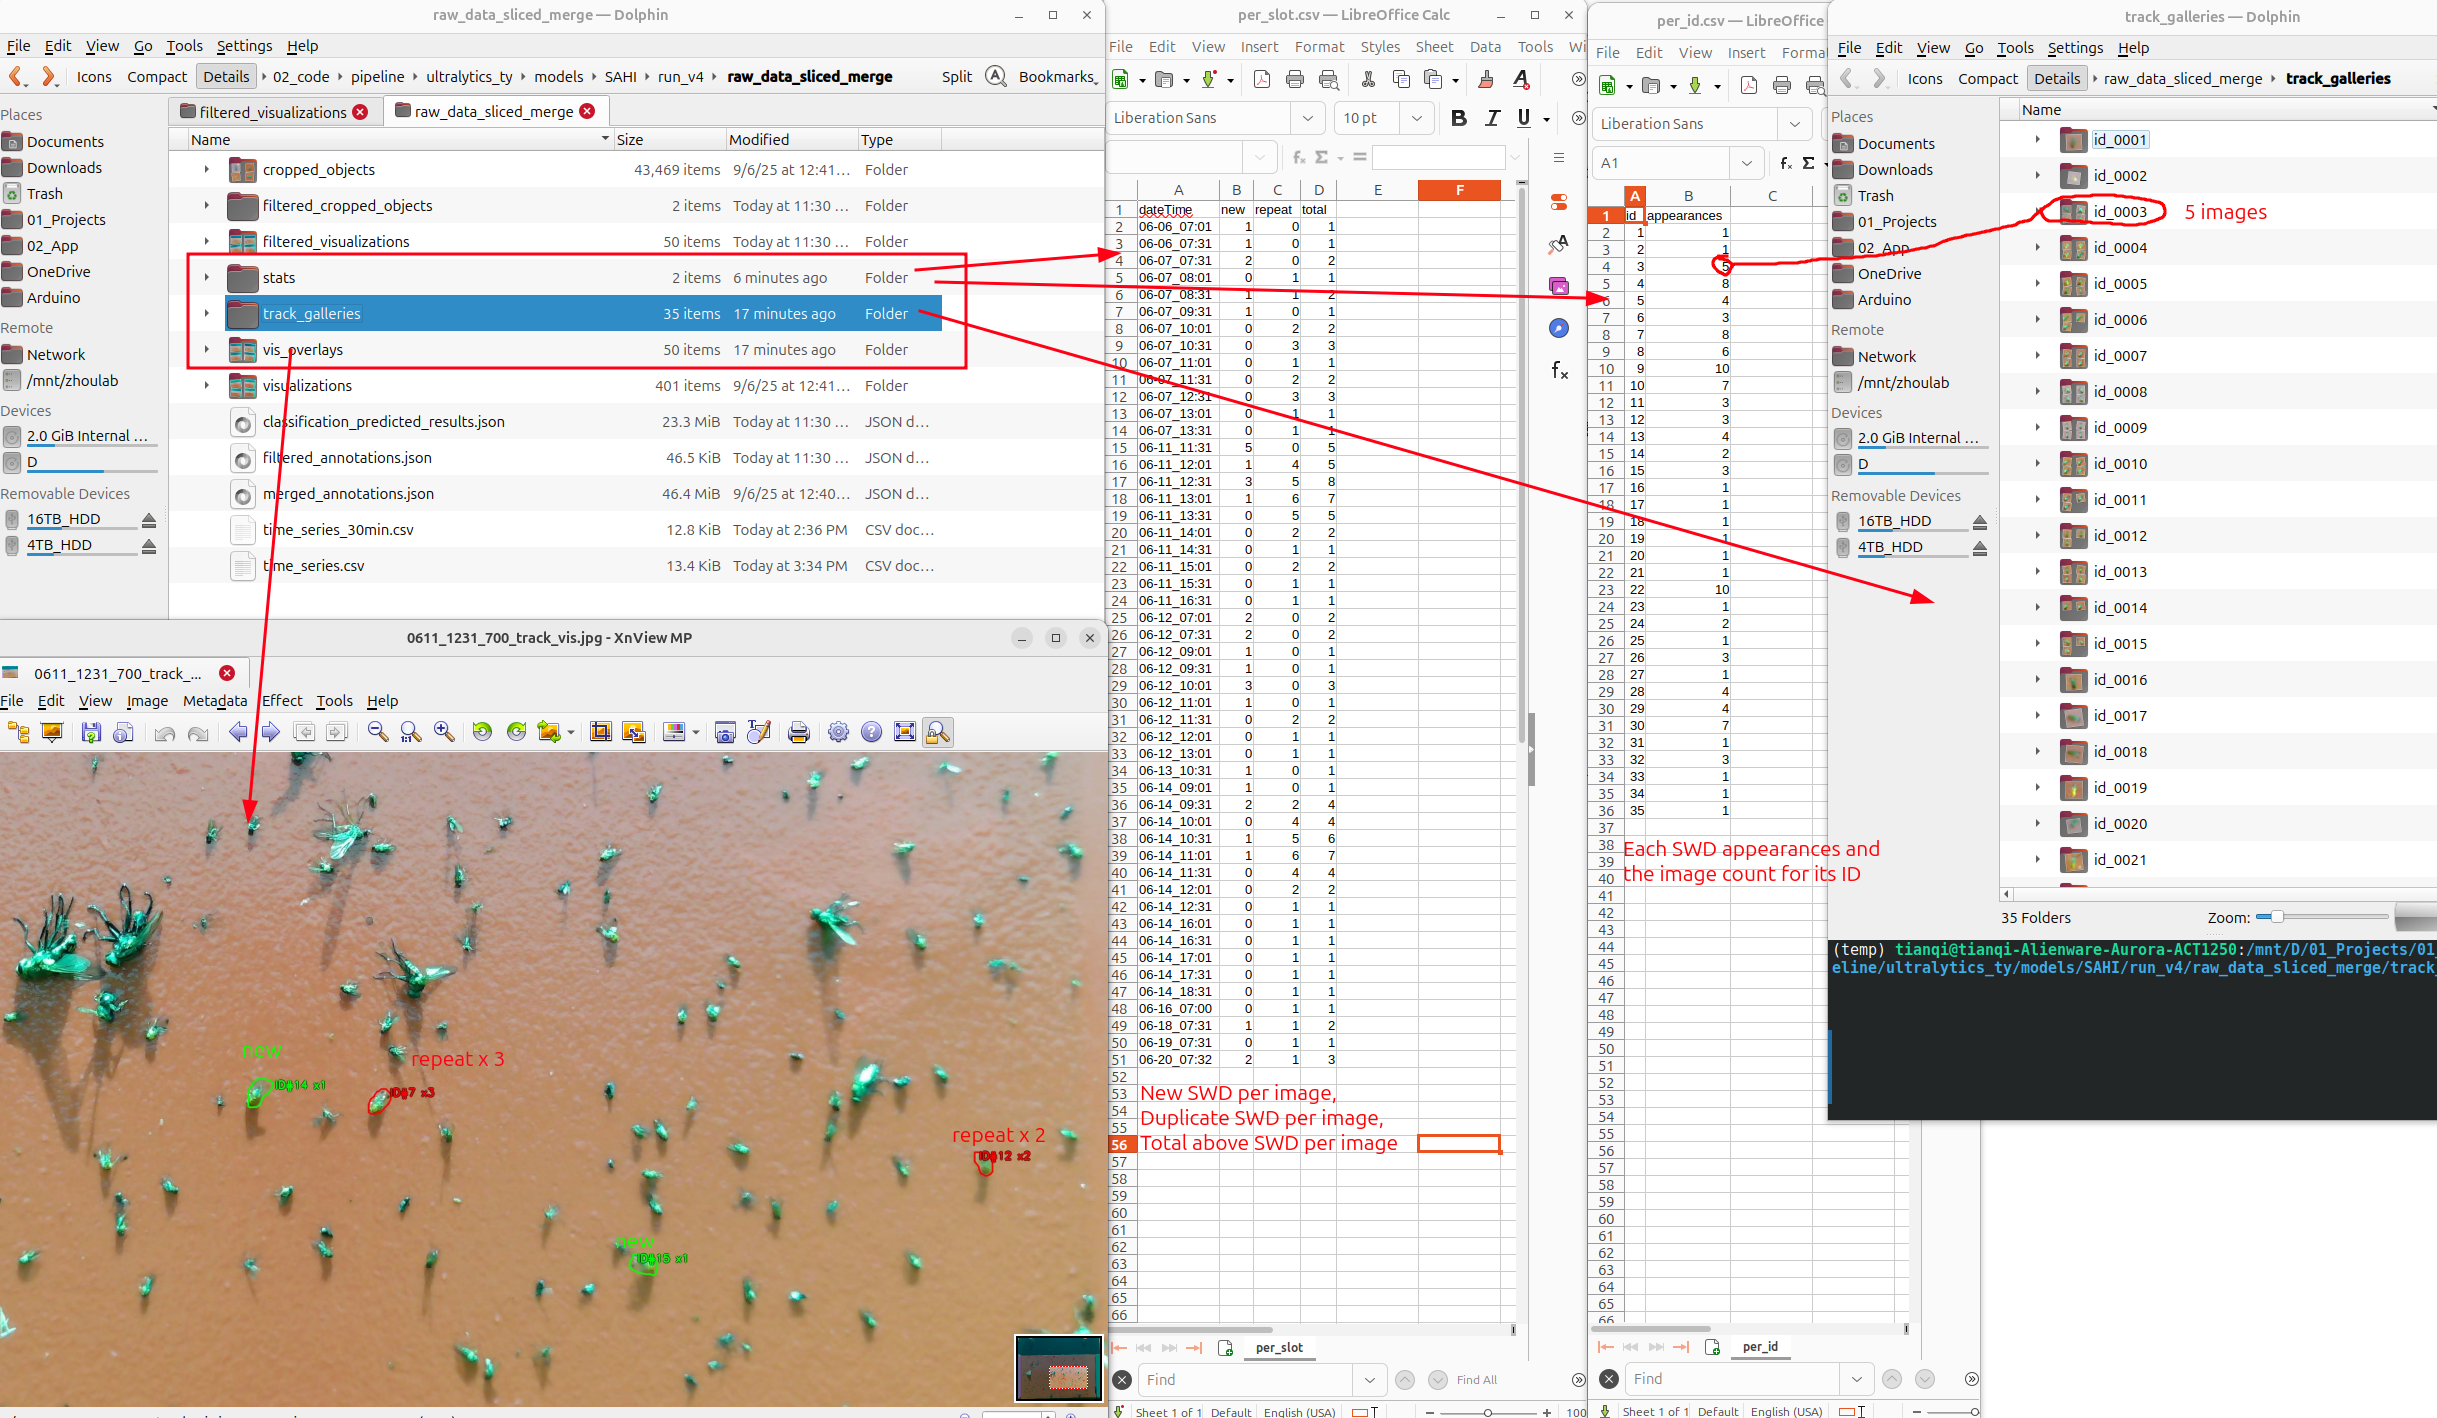

In [13]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os, math, csv, re
from pathlib import Path
from collections import defaultdict, Counter
from typing import Any, Dict, List, Optional, Tuple

import orjson
import numpy as np
import cv2

# ============== 可选 shapely（用于多边形 IOS/IOU），无则自动退回 bbox ==============
try:
    from shapely.geometry import Polygon
    _HAVE_SHAPELY = True
except Exception:
    _HAVE_SHAPELY = False

# ============== 时间解析（与你现有命名一致：MMDD_HHMM） ==============
_FN_RE = re.compile(r"(?P<mm>\d{2})(?P<dd>\d{2})_(?P<hh>\d{2})(?P<mi>\d{2})")

def _parse_mmdd_hhmm(img_name: str):
    m = _FN_RE.search(img_name)
    if not m: return None
    mm, dd, hh, mi = m.group("mm", "dd", "hh", "mi")
    return f"{mm}-{dd}", f"{hh}:{mi}"

def _time_sort_key(t: str):
    return (int(t[:2]), int(t[3:]))

# ============== IO ==============
def json_load(path: str):
    with open(path, "rb") as f:
        return orjson.loads(f.read())

def json_dump(obj, path: str):
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    with open(path, "wb") as f:
        f.write(orjson.dumps(obj, option=orjson.OPT_INDENT_2))

# ============== 原图索引 ==============
def _build_image_index(original_image_dir: str) -> Dict[str, str]:
    idx: Dict[str, str] = {}
    for p in Path(original_image_dir).glob("*.jpg"):
        idx[p.stem] = str(p)
    return idx

# ============== 几何工具 ==============
def _poly_from_segments(segments: Dict[str, List[float]]) -> Optional[List[List[float]]]:
    xs = segments.get("x") or segments.get("xs") or []
    ys = segments.get("y") or segments.get("ys") or []
    if not xs or not ys or len(xs) != len(ys): return None
    return [[float(x), float(y)] for x, y in zip(xs, ys)]

def _poly_from_bbox(b) -> Optional[List[List[float]]]:
    if b is None: return None
    try:
        if isinstance(b, (list, tuple)) and len(b) >= 4:
            x, y, w, h = map(float, b[:4])
            if w > 0 and h > 0:
                x1, y1, x2, y2 = x, y, x + w, y + h
            else:
                x1, y1, x2, y2 = map(float, b[:4])
        elif isinstance(b, dict):
            if all(k in b for k in ("x1","y1","x2","y2")):
                x1, y1, x2, y2 = float(b["x1"]), float(b["y1"]), float(b["x2"]), float(b["y2"])
            else:
                x = float(b.get("x")); y = float(b.get("y"))
                w = float(b.get("w") or b.get("width")); h = float(b.get("h") or b.get("height"))
                x1, y1, x2, y2 = x, y, x + w, y + h
        else:
            return None
        if x2 <= x1 or y2 <= y1: return None
        return [[x1,y1],[x2,y1],[x2,y2],[x1,y2]]
    except Exception:
        return None

def _poly_to_bbox(poly: List[List[float]]) -> Tuple[float,float,float,float]:
    xs = [p[0] for p in poly]; ys = [p[1] for p in poly]
    return min(xs), min(ys), max(xs), max(ys)

def _area_bbox(b):
    return max(0.0, b[2]-b[0]) * max(0.0, b[3]-b[1])

def _bbox_center(b: Tuple[float,float,float,float]) -> Tuple[float,float]:
    return (b[0]+b[2]) * 0.5, (b[1]+b[3]) * 0.5

def _center_distance(b1, b2) -> float:
    c1 = _bbox_center(b1); c2 = _bbox_center(b2)
    return math.hypot(c1[0]-c2[0], c1[1]-c2[1])

def _iou_bbox(a, b) -> float:
    xA = max(a[0], b[0]); yA = max(a[1], b[1])
    xB = min(a[2], b[2]); yB = min(a[3], b[3])
    inter = max(0.0, xB-xA) * max(0.0, yB-yA)
    if inter <= 0: return 0.0
    u = _area_bbox(a) + _area_bbox(b) - inter
    return inter / u if u > 0 else 0.0

def _ios_bbox(a, b) -> float:
    xA = max(a[0], b[0]); yA = max(a[1], b[1])
    xB = min(a[2], b[2]); yB = min(a[3], b[3])
    inter = max(0.0, xB-xA) * max(0.0, yB-yA)
    if inter <= 0: return 0.0
    smaller = min(_area_bbox(a), _area_bbox(b))
    return inter / smaller if smaller > 0 else 0.0

def _iou_poly(pa, pb) -> float:
    if not _HAVE_SHAPELY:
        return _iou_bbox(_poly_to_bbox(pa), _poly_to_bbox(pb))
    try:
        A = Polygon(pa); B = Polygon(pb)
        inter = A.intersection(B).area
        if inter <= 0: return 0.0
        u = A.area + B.area - inter
        return inter / u if u > 0 else 0.0
    except Exception:
        return _iou_bbox(_poly_to_bbox(pa), _poly_to_bbox(pb))

def _ios_poly(pa, pb) -> float:
    if not _HAVE_SHAPELY:
        return _ios_bbox(_poly_to_bbox(pa), _poly_to_bbox(pb))
    try:
        A = Polygon(pa); B = Polygon(pb)
        inter = A.intersection(B).area
        if inter <= 0: return 0.0
        smaller = min(A.area, B.area)
        return inter / smaller if smaller > 0 else 0.0
    except Exception:
        return _ios_bbox(_poly_to_bbox(pa), _poly_to_bbox(pb))

def _extract_poly(obj: Dict[str,Any]) -> Optional[List[List[float]]]:
    pts = obj.get("points") or obj.get("polygon")
    if isinstance(pts, list) and len(pts) >= 3:
        return [[float(x), float(y)] for x, y in pts]
    seg = obj.get("segments") or obj.get("segment")
    if isinstance(seg, dict):
        p = _poly_from_segments(seg)
        if p: return p
    box = obj.get("box") or obj.get("Box")
    if box is not None:
        p = _poly_from_bbox(box)
        if p: return p
    bb = obj.get("bbox") or obj.get("BBox")
    if bb is not None:
        p = _poly_from_bbox(bb)
        if p: return p
    return None

# ============== 赋持久 ID（跨时刻去重，与累计逻辑一致） ==============
def assign_persistent_ids(
    cleaned_annotations: Dict[str, List[Dict[str,Any]]],
    match_metric: str = "poly_ios",     # 'poly_ios' | 'poly_iou' | 'bbox_ios' | 'bbox_iou'
    match_threshold: float = 0.5,
    center_thresh: Optional[float] = 20.0,
    class_agnostic: bool = False
):
    # —— 组织按时间顺序 —— 
    by_date_time: Dict[Tuple[str,str], List[Tuple[str,Dict]]] = defaultdict(list)
    for img, anns in cleaned_annotations.items():
        parsed = _parse_mmdd_hhmm(img)
        if not parsed: 
            continue
        d, t = parsed
        for a in anns:
            poly = _extract_poly(a)
            by_date_time[(d,t)].append((img, {"label": str(a.get("label","")), "poly": poly}))

    slots = sorted(by_date_time.keys(), key=lambda k: (int(k[0][:2]), int(k[0][3:]), *_time_sort_key(k[1])))

    # —— 度量函数 —— 
    mm = match_metric.lower()
    def score(pa, pb):
        if "poly" in mm and (pa is not None) and (pb is not None):
            return _ios_poly(pa, pb) if "ios" in mm else _iou_poly(pa, pb)
        # fallback bbox
        if pa is None or pb is None: return 0.0
        ba, bb = _poly_to_bbox(pa), _poly_to_bbox(pb)
        if center_thresh is not None and _center_distance(ba, bb) > center_thresh:
            return 0.0
        return _ios_bbox(ba, bb) if "ios" in mm else _iou_bbox(ba, bb)

    # —— 已见库 & 输出结构 —— 
    next_id = 1
    # 全局池：按 label 或不分 label
    pool_by_label = defaultdict(list)  # label -> List[{'id','poly','last_dt'}]
    pool_all: List[Dict[str,Any]] = []
    id_tracks = defaultdict(list)      # id -> List[{'date','time','img','poly','label','repeat_idx'}]
    timeline = []                      # 每条观测（时序展开）

    for (d,t) in slots:
        obs = by_date_time[(d,t)]  # List[(img, det)]
        # 先做“本时刻内部去重”
        unique_obs: List[Tuple[str,Dict]] = []
        for img, det in obs:
            # 与已加入 unique 对比
            dup_in_row = False
            for _, u in unique_obs:
                if (not class_agnostic) and (u["label"] != det["label"]):
                    continue
                if score(det["poly"], u["poly"]) >= match_threshold:
                    dup_in_row = True
                    break
            if not dup_in_row:
                unique_obs.append((img, det))

        # 与历史库匹配 → 赋 ID
        for img, det in unique_obs:
            label, poly = det["label"], det["poly"]
            candidates = pool_all if class_agnostic else pool_by_label[label]
            best = None; best_s = -1.0
            if poly is not None:
                for c in candidates:
                    s = score(poly, c["poly"])
                    if s >= match_threshold and s > best_s:
                        best = c; best_s = s

            if best is None:
                # 新 ID
                cur_id = next_id; next_id += 1
                entry = {"id": cur_id, "poly": poly, "last_dt": (d,t)}
                if class_agnostic: pool_all.append(entry)
                else: pool_by_label[label].append(entry)
                repeat_idx = 1
            else:
                # 复现
                cur_id = best["id"]
                best["poly"] = poly if poly is not None else best["poly"]
                best["last_dt"] = (d,t)
                repeat_idx = len(id_tracks[cur_id]) + 1

            id_tracks[cur_id].append({
                "date": d, "time": t, "img": img, "poly": poly, "label": label, "repeat_idx": repeat_idx
            })
            timeline.append({
                "date": d, "time": t, "img": img, "label": label,
                "id": cur_id, "is_new": repeat_idx == 1, "repeat_idx": repeat_idx, "poly": poly
            })

    return timeline, id_tracks

# ============== 可视化：叠加绘制（新=绿，重复=红，标注 ID×出现次数） ==============
def draw_overlays(
    timeline: List[Dict[str,Any]],
    original_image_dir: str,
    out_dir: str,
    draw_text: bool = True,
    ghost_trail_steps: int = 0,          # >0 开启“幽灵轨迹”
    ghost_alpha: float = 0.25            # 幽灵透明度
):
    os.makedirs(out_dir, exist_ok=True)
    image_index = _build_image_index(original_image_dir)

    # 分图聚合
    by_img = defaultdict(list)
    for r in timeline:
        by_img[r["img"]].append(r)

    # 为“幽灵轨迹”建立 id -> 历史 occurrences
    hist_by_id = defaultdict(list)
    # 先按时间排序
    def dt_key(r): return (int(r["date"][:2]), int(r["date"][3:]), int(r["time"][:2]), int(r["time"][3:]))
    timeline_sorted = sorted(timeline, key=dt_key)
    for r in timeline_sorted:
        hist_by_id[r["id"]].append(r)

    for img, rows in by_img.items():
        path = image_index.get(img)
        if path is None or not os.path.exists(path):
            # 兜底：前缀匹配
            for p in Path(original_image_dir).glob(f"{img}*.jpg"):
                path = str(p); break
        if path is None or not os.path.exists(path):
            continue

        canvas = cv2.imread(path)
        if canvas is None: 
            continue
        H, W = canvas.shape[:2]

        # 先画幽灵轨迹（淡色）
        if ghost_trail_steps > 0:
            ghost = canvas.copy()
            for r in rows:
                tr = hist_by_id[r["id"]]
                # 找到当前出现位置
                idx = None
                for i, k in enumerate(tr):
                    if k["img"] == img: idx = i; break
                if idx is None: continue
                start = max(0, idx - ghost_trail_steps)
                for j in range(start, idx):
                    pj = tr[j]
                    if pj["poly"] is None: continue
                    pts = np.asarray(pj["poly"], dtype=np.int32).reshape(-1,1,2)
                    cv2.polylines(ghost, [pts], True, (200,200,200), 1, cv2.LINE_AA)
            canvas = cv2.addWeighted(ghost, ghost_alpha, canvas, 1-ghost_alpha, 0)

        # 再画当前 detections（新=绿，重复=红）
        for r in rows:
            poly = r["poly"]
            if poly is None: 
                continue
            pts = np.asarray(poly, dtype=np.int32).reshape(-1,1,2)
            color = (0,255,0) if r["is_new"] else (0,0,255)
            cv2.polylines(canvas, [pts], True, color, 2, cv2.LINE_AA)

            if draw_text:
                x1, y1, x2, y2 = _poly_to_bbox(poly)
                x0, y0 = int(x1) + 8, int(y1) + 18

                label = str(r.get("label", "?"))  # e.g. "swd" / "mayswd"
                txt = f"ID#{r['id']} {label} x{r['repeat_idx']}"  # ← 这里加了类别
                
                SHIFT_X = 64
                cv2.putText(canvas, txt, (x0 + SHIFT_X, y0), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2, cv2.LINE_AA)

        out_path = os.path.join(out_dir, f"{img}_track_vis.jpg")
        cv2.imwrite(out_path, canvas, [int(cv2.IMWRITE_JPEG_QUALITY), 90])

# ============== 轨迹相册：按 ID 导出裁剪序列（时间排序） ==============
def _crop_square(img, poly, margin: int = 8):
    H, W = img.shape[:2]
    xs = [p[0] for p in poly]; ys = [p[1] for p in poly]
    x1, y1, x2, y2 = int(min(xs)), int(min(ys)), int(max(xs)), int(max(ys))
    side = max(x2 - x1, y2 - y1)
    cx = (x1 + x2) // 2; cy = (y1 + y2) // 2
    l = max(0, cx - side//2 - margin)
    t = max(0, cy - side//2 - margin)
    r = min(W, cx + side//2 + margin)
    b = min(H, cy + side//2 + margin)
    if r - l <= 1 or b - t <= 1: return None
    return img[t:b, l:r].copy()

def build_track_galleries(
    id_tracks: Dict[int, List[Dict[str,Any]]],
    original_image_dir: str,
    out_dir: str,
    margin: int = 8,
    workers: Optional[int] = None,     # 默认自动选择线程数
    jpeg_quality: int = 90             # 可降到 80 进一步省 CPU
):
    """
    加速点：
    1) 先把所有裁剪任务按原图分组；每张原图只 imread 一次。
    2) 用 ThreadPoolExecutor 并发处理各原图（I/O 密集型非常合适）。
    3) 目录预创建，减少热路径上的 os.makedirs 调用。
    4) 复用 JPEG 编码参数对象，避免重复创建临时列表。
    """
    import concurrent.futures

    os.makedirs(out_dir, exist_ok=True)
    image_index = _build_image_index(original_image_dir)

    # 预创建每个 id 的输出目录，避免任务线程中频繁创建
    save_dirs = {}
    for tid in id_tracks.keys():
        d = os.path.join(out_dir, f"id_{tid:04d}")
        os.makedirs(d, exist_ok=True)
        save_dirs[tid] = d

    # —— 准备任务：按原图聚合 —— #
    # tasks_by_img[path] = List[ (poly, save_path) ]
    tasks_by_img: Dict[str, List[Tuple[List[List[float]], str]]] = defaultdict(list)

    # prefix fallback 做缓存，避免多次 glob
    _fallback_cache: Dict[str, Optional[str]] = {}

    for tid, occs in id_tracks.items():
        # 时间排序，确定文件名中的序号 k
        occs_sorted = sorted(
            occs, key=lambda r: (int(r["date"][:2]), int(r["date"][3:]), int(r["time"][:2]), int(r["time"][3:]))
        )
        for k, r in enumerate(occs_sorted, start=1):
            if r.get("poly") is None:
                continue

            img_key = r["img"]
            img_path = image_index.get(img_key)
            if img_path is None:
                if img_key not in _fallback_cache:
                    hit = None
                    for p in Path(original_image_dir).glob(f"{img_key}*.jpg"):
                        hit = str(p); break
                    _fallback_cache[img_key] = hit
                img_path = _fallback_cache[img_key]

            if not img_path or not os.path.exists(img_path):
                continue

            fn = f"{k:02d}_{r['date']}_{r['time']}_{r['img']}.jpg"
            save_path = os.path.join(save_dirs[tid], fn)
            tasks_by_img[img_path].append((r["poly"], save_path))

    if not tasks_by_img:
        return  # 无任务直接返回

    # —— 线程 worker：一次性读图，批量裁剪写出 —— #
    encode_params = [int(cv2.IMWRITE_JPEG_QUALITY), int(jpeg_quality)]

    def _process_one_image(img_path: str, todo: List[Tuple[List[List[float]], str]]):
        img = cv2.imread(img_path)
        if img is None:
            return 0
        ok = 0
        for poly, save_path in todo:
            crop = _crop_square(img, poly, margin=margin)
            if crop is None:
                continue
            # 写文件（等价于 imwrite），复用编码参数，减少开销
            cv2.imwrite(save_path, crop, encode_params)
            ok += 1
        return ok

    # —— 并发执行 —— #
    if workers is None:
        # I/O 密集：线程数略高于 CPU 核心；也可手动传入
        workers = min(32, (os.cpu_count() or 4) + 4)

    total_ok = 0
    with concurrent.futures.ThreadPoolExecutor(max_workers=workers) as ex:
        futs = [ex.submit(_process_one_image, path, todo) for path, todo in tasks_by_img.items()]
        for fut in concurrent.futures.as_completed(futs):
            try:
                total_ok += fut.result()
            except Exception:
                pass  # 可按需记录日志

    # 可根据需要打印/返回 total_ok
    # print(f"[build_track_galleries] crops saved: {total_ok}")


# ============== 统计导出：每时刻新增/重复 & 每 ID 出现次数 ==============
def export_stats_csv(
    timeline: List[Dict[str,Any]],
    csv_per_slot: str,
    csv_per_id: str
):
    """
    依据 assign_persistent_ids 产生的 timeline 导出两张表：
      1) 每时槽统计（csv_per_slot）：
         列包含 dateTime, new, repeat, total, cumulative_total,
         以及对每个类别的 <lbl>_new, <lbl>_repeat, <lbl>, <lbl>_cumulative
         - 累计按 is_new 计算：只在“首次出现”的时槽对累计 +1（与去重累计一致）
         - 时槽仅覆盖真实存在的捕获时间（不做全天补齐；需要补齐请用 build_time_series 的输出）

      2) 每 ID 出现次数（csv_per_id）：保持原样（id, appearances）
    """
    from collections import defaultdict, Counter

    # ---- 收集标签全集 ----
    labels = sorted({str(r.get("label","")) for r in timeline})

    # ---- 聚合到时槽 ----
    def slot_key(r):
        # r["date"] = "MM-DD", r["time"] = "HH:MM"
        return (int(r["date"][:2]), int(r["date"][3:]), int(r["time"][:2]), int(r["time"][3:]))

    # 结构：key -> 聚合
    # key 形如 "MM-DD_HH:MM"
    per_slot_totals = defaultdict(lambda: {"new":0, "repeat":0, "total":0})
    per_slot_new_by_lbl = defaultdict(Counter)
    per_slot_rep_by_lbl = defaultdict(Counter)

    for r in timeline:
        dt_key = f"{r['date']}_{r['time']}"
        per_slot_totals[dt_key]["total"] += 1
        if r.get("is_new", False):
            per_slot_totals[dt_key]["new"] += 1
            per_slot_new_by_lbl[dt_key][str(r.get("label",""))] += 1
        else:
            per_slot_totals[dt_key]["repeat"] += 1
            per_slot_rep_by_lbl[dt_key][str(r.get("label",""))] += 1

    # ---- 按时间排序时槽 ----
    # 从 timeline 直接拿到所有真实时槽并排序，避免字符串切片排序出错
    all_slots = sorted(
        { (r["date"], r["time"]) for r in timeline },
        key=lambda dt: (int(dt[0][:2]), int(dt[0][3:]), int(dt[1][:2]), int(dt[1][3:]))
    )
    sorted_keys = [f"{d}_{t}" for d, t in all_slots]

    # ---- 写每时槽 CSV（包含每类累计）----
    Path(csv_per_slot).parent.mkdir(parents=True, exist_ok=True)

    header = ["dateTime", "new", "repeat", "total", "cumulative_total"]
    # 每类：new / repeat / total（即时）+ cumulative（去重累计）
    for lbl in labels:
        header += [f"{lbl}_new", f"{lbl}_repeat", f"{lbl}", f"{lbl}_cumulative"]

    running_cum_total = 0
    running_cum_by_lbl = {lbl: 0 for lbl in labels}

    with open(csv_per_slot, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(header)

        for k in sorted_keys:
            base = per_slot_totals[k]
            new_by_lbl = per_slot_new_by_lbl[k]
            rep_by_lbl = per_slot_rep_by_lbl[k]

            # 更新累计（按 is_new 统计）
            running_cum_total += base["new"]
            for lbl in labels:
                running_cum_by_lbl[lbl] += new_by_lbl.get(lbl, 0)

            row = [k, base["new"], base["repeat"], base["total"], running_cum_total]

            # 逐类填充：new / repeat / total(=new+repeat) / cumulative
            for lbl in labels:
                n = new_by_lbl.get(lbl, 0)
                r_ = rep_by_lbl.get(lbl, 0)
                row += [n, r_, n + r_, running_cum_by_lbl[lbl]]

            w.writerow(row)

    # ---- 写每 ID 出现次数（保持原行为）----
    count_by_id = Counter([r["id"] for r in timeline])
    label_by_id = {}
    for r in timeline:
        if r["id"] not in label_by_id:
            label_by_id[r["id"]] = r.get("label","")
    with open(csv_per_id, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["id","appearances", "label"])
        for tid in sorted(count_by_id.keys()):
            w.writerow([tid, count_by_id[tid], label_by_id.get(tid,"")])


In [14]:
for d in chosen_dirs:
    print(f"\n=========轨迹分析目录：{d} =========")
    filtered_annotations_json_path = d.parent / "raw_data_sliced_merge" / f"filtered_annotations_{version}.json"
    original_image_dir = d.parent / "raw_data"
    out_vis_overlays_dir = d.parent / "raw_data_sliced_merge" / f"06_vis_overlays_{version}"
    out_track_galleries_dir = d.parent / "raw_data_sliced_merge" / f"06_track_galleries_{version}"
    out_stats_per_slot_csv = d.parent / "raw_data_sliced_merge" / f"06_stats_{version}" / "per_slot.csv"
    out_stats_per_id_csv = d.parent / "raw_data_sliced_merge" / f"06_stats_{version}" / "per_id.csv"

    # 1) 读入你“清洗后的”标注（每张原图一个数组，points 已经对齐）
    cleaned = json_load(filtered_annotations_json_path)

    # 2) 先赋持久 ID（参数与累计一致）
    timeline, id_tracks = assign_persistent_ids(
        cleaned_annotations=cleaned,
        match_metric="poly_ios",       # 'poly_ios' | 'poly_iou' | 'bbox_ios' | 'bbox_iou'
        match_threshold=0.5,
        center_thresh=20.0,
        class_agnostic=False
    )

    # 3) 叠加可视化（新=绿，重复=红，ID×次数；可开启幽灵轨迹 ghost_trail_steps）
    draw_overlays(
        timeline,
        original_image_dir=original_image_dir,
        out_dir=out_vis_overlays_dir,
        draw_text=True,
        ghost_trail_steps=2,    # 0 关闭；2 表示叠加过去2次的位置（淡灰）
        ghost_alpha=0.25
    )

    # 4) 为每个 ID 导出“轨迹相册”（按时间排序的一组裁剪小图）
    build_track_galleries(
        id_tracks,
        original_image_dir=original_image_dir,
        out_dir=out_track_galleries_dir,
        margin=8
    )

    # 5) 导出统计表（可用你喜欢的图表工具画）
    export_stats_csv(
        timeline,
        csv_per_slot=out_stats_per_slot_csv,   # 每个时刻：new / repeat / total
        csv_per_id=out_stats_per_id_csv        # 每个ID出现次数
    )

    # 6) 根据out_stats_per_id_csv，重命名轨迹相册目录
    id_rename_map = {}
    with open(out_stats_per_id_csv, "r", encoding="utf-8") as f:
        r = csv.reader(f)
        next(r)  # skip header
        for row in r:
            if len(row) >= 3:
                tid = int(row[0])
                appearances = int(row[1])
                label = row[2] or "unknown"
                id_rename_map[tid] = (appearances, label)
    for tid, (appearances, label) in id_rename_map.items():
        src_dir = out_track_galleries_dir / f"id_{tid:04d}"
        if not src_dir.exists():
            continue
        dst_dir = out_track_galleries_dir / f"id_{tid:04d}_x{appearances}_{label}"
        if dst_dir.exists():
            continue
        src_dir.rename(dst_dir)



=========轨迹分析目录：/workspace/models/SAHI/run_v7/ms1_0726-0809_11/raw_data =========

=========轨迹分析目录：/workspace/models/SAHI/run_v7/air1_0729-0813_5/raw_data =========

=========轨迹分析目录：/workspace/models/SAHI/run_v7/air1_0826-0909_21_no/raw_data =========

=========轨迹分析目录：/workspace/models/SAHI/run_v7/air2_0729-0813_04/raw_data =========

=========轨迹分析目录：/workspace/models/SAHI/run_v7/air2_0826-0909_25_no/raw_data =========

=========轨迹分析目录：/workspace/models/SAHI/run_v7/jeff_0613-0624_04_ok/raw_data =========

=========轨迹分析目录：/workspace/models/SAHI/run_v7/jeff_0624-0702_01_ok/raw_data =========

=========轨迹分析目录：/workspace/models/SAHI/run_v7/jeff_0730-0813_01/raw_data =========

=========轨迹分析目录：/workspace/models/SAHI/run_v7/lloyd_0603-0618_31/raw_data =========

=========轨迹分析目录：/workspace/models/SAHI/run_v7/lloyd_0715-0729_04/raw_data =========

=========轨迹分析目录：/workspace/models/SAHI/run_v7/lloyd_0826-0909_04/raw_data =========

=========轨迹分析目录：/workspace/models/SAHI/run_v7/ms1_0605-0621_40